# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [3]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [4]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

# 파생 변수
df['Age'] = 2024 - df['Year_Birth'] #고객 나이
df['Total_Spending'] = df[spending_cols].sum(axis=1) # 6개의 카테고리에 대한 총 지출액 (고객의 총 구매액)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1) #총 구매 횟수 (웹+카탈로그+매장)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1) # 수락한 캠페인 수
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0 # 자녀 우무
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High']) #소득 3분위 그룹 범주화

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age) #연령대 구간별 그룹

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map) # 학력 3단계 범주화 (학부/졸업/대학원)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'} 
df['Marital_Group'] = df['Marital_Status'].map(marital_map) # 가족 유무 (함께살고있는지 / 싱글)

df['Campaign_Response'] = df['Total_Accepted'] > 0 # 캠페인 1회 이상 수락한 여부 (True/False)

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y') #가입 시기를 date타입으로 타입 변경
reference_date = df['Dt_Customer'].max() #최신 날짜 (이 데이터의 가장 최근 날짜)
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days #가입 후 경과 일수

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [5]:
#IQR, STD, 도메인기반
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [6]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균, 가중평균(X)
target_cols = ['Income', 'Total_Spending', 'Age']


for col in target_cols :
    col_mean = df[col].mean()
    col_median =  df[col].median()
    print(col_mean, col_median)
    print()

results = df[target_cols].agg(lambda data : pd.Series({
    '평균':data.mean(),
    '중앙값':data.median(),
    '최빈값':data.mode().iloc[0],
    '절사평균(5%)': trim_mean(data, 0.05),
}))
display(results)

51952.61404293381 51381.5

605.9865831842576 396.5

55.10196779964222 54.0



,Income,Total_Spending,Age
평균,51952.614043,605.986583,55.101968
중앙값,51381.500000,396.500000,54.000000
최빈값,51381.500000,46.000000,48.000000
절사평균(5%),51740.153426,561.119662,55.074975


In [7]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%), 범위 (X)

results = df[target_cols].agg(lambda data : pd.Series({
    '분산':data.var(ddof=1),
    '표준편차':data.std(ddof=1),
    'IQR':data.quantile(0.75) - data.quantile(0.25),
    'CV(%)': data.std(ddof=1) / data.mean() *100,
    '범위': data.max() - data.min(),
}))
display(results.round(0))

,Income,Total_Spending,Age
분산,458450913.0,362242.0,137.0
표준편차,21411.0,602.0,12.0
IQR,32773.0,976.0,18.0
CV(%),41.0,99.0,21.0
범위,160667.0,2520.0,56.0


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

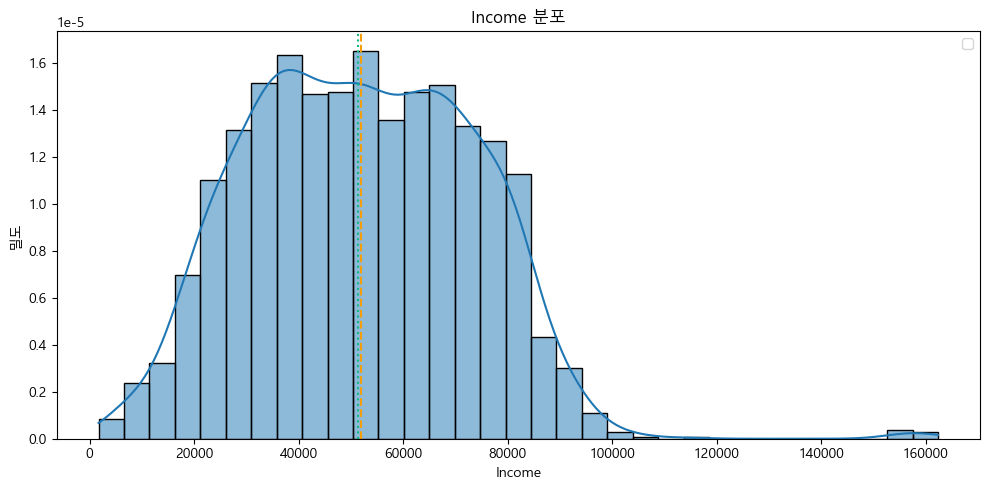

In [8]:
# TODO 1-2(a): Income 히스토그램 + KDE
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df['Income'], kde=True, stat='density')
ax.axvline(df['Income'].mean(), color=COLORS['amber'], ls='--')
ax.axvline(df['Income'].median(), color=COLORS['emerald'], ls=':')
ax.set(xlabel='Income', ylabel='밀도', title='Income 분포')
ax.legend()
plt.tight_layout()
plt.show()

이상치 개수 3


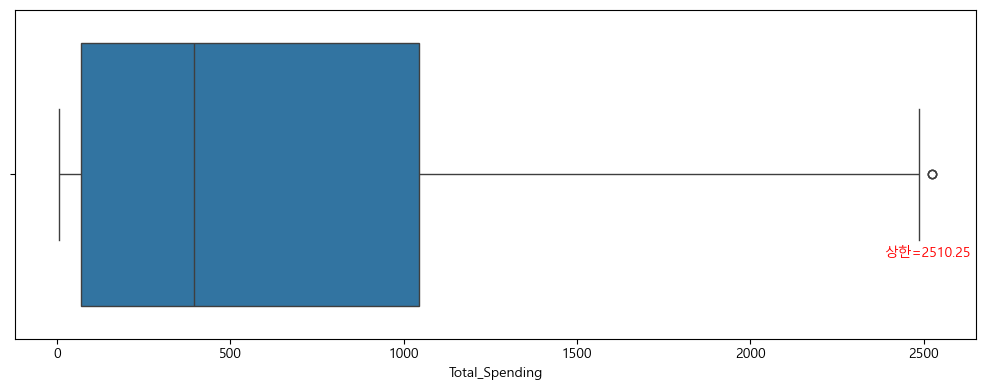

In [9]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=df['Total_Spending'], ax=ax)

q1 = df['Total_Spending'].quantile(0.25)
q3 = df['Total_Spending'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr
outliers = df[(df['Total_Spending']>upper_bound) | (df['Total_Spending']<lower_bound)]
print("이상치 개수", len(outliers))

ax.annotate(f'상한={upper_bound}', xy=(upper_bound, 0), xytext=(upper_bound, 0.25), ha='center', color='red')

plt.tight_layout()
plt.show()



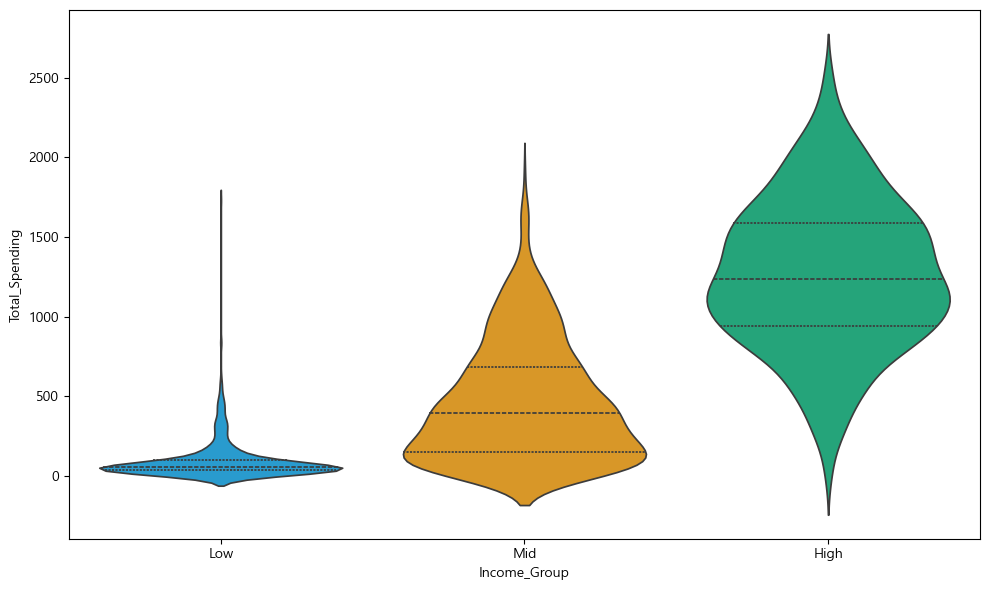

In [10]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=df, x='Income_Group', y='Total_Spending', order=['Low', 'Mid', 'High'], inner='quartile', ax=ax, palette=[COLORS['sky'], COLORS['amber'], COLORS['emerald']])

plt.tight_layout()
plt.show()


### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [11]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']


# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
results = df[spending_cols].agg(lambda data : pd.Series({
    '왜도':data.skew(),
    '첨도':data.kurt()

}))
results.columns = spending_names

display(results.round(2))


,Wines,Fruits,Meat,Fish,Sweets,Gold
왜도,1.18,2.10,2.09,1.92,2.14,1.89
첨도,0.60,4.07,5.53,3.10,4.37,3.56


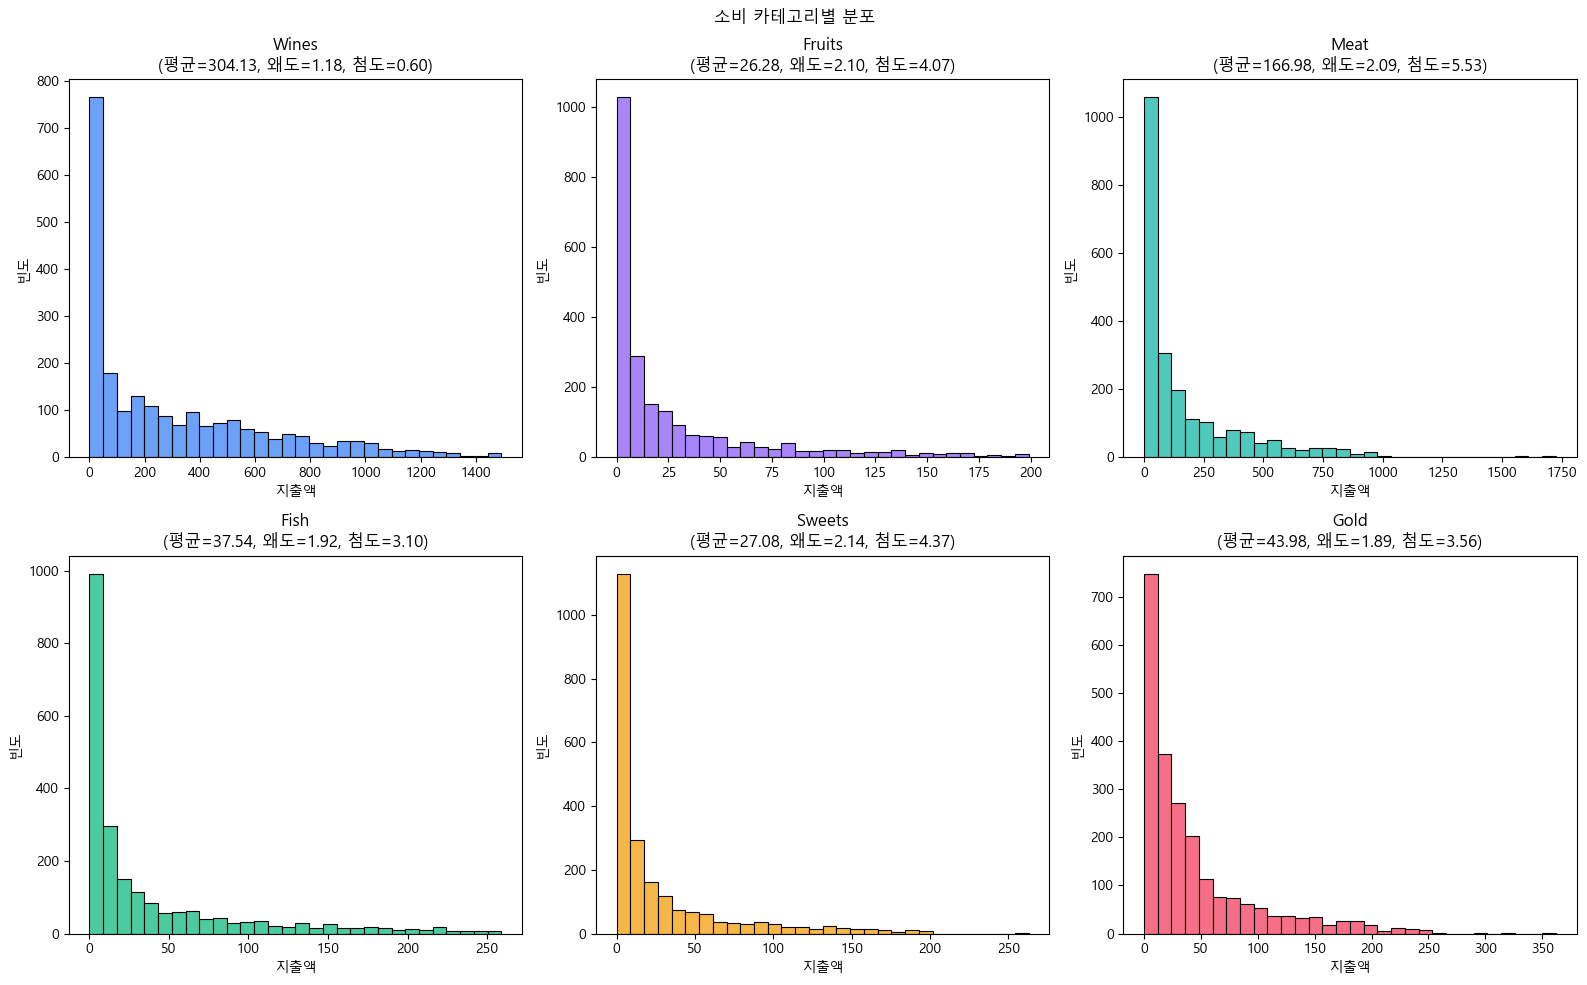

In [12]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)

hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for ax, col, name, color in zip(axes.ravel(), spending_cols, spending_names, hist_colors) :
    s, k, m = df[col].skew(), df[col].kurt(), df[col].mean()
    sns.histplot(df[col], bins=30, color=color, ax=ax)
    ax.set(xlabel='지출액', ylabel='빈도', title=f'{name}\n(평균={m:.2f}, 왜도={s:.2f}, 첨도={k:.2f})')

plt.suptitle('소비 카테고리별 분포')
plt.tight_layout()
plt.show()

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [13]:
# TODO 1-4: 비즈니스 인사이트 정리

# 1. 고객 특성
# 평균 연령 55세, 주 고객층이 중장년이다
# 중위 소득 51,382다 -> 소득 분포는 거의 종 모양
# 총 소비 평균 606, 중앙값 396, 왜도 0.86, cv=99% --> 고객간 소비 편차가 매우 크다
# 자녀 보유 비율 (자녀 있는지 없는지 비율에 따른 총 소비액), 캠페인 참여 여부에 따른 총 소비액


# 2. 핵심발견
# - Income : 정규 분포에 가깝다.
# - 총 소비액 : 오른쪽 꼬리가 길고, 고소득 VIP 고객들와 저소득 고객으로 양극화 되어있다.
# - 와인 > 고기 > 골드 > ... 각 카테고리별 총 소비의 비율 --> 파이차트 
# - 소득 그룹간 소비 격차가 뚜렷했다 (바인올린 플롯)

# 3. 후속 분석 가설 :
# H1 : 자녀의 유무에 따라 소비의 차이가 있다
# H2 : 같은 고객이 와인과 육류에 쓰는 금액에 차이가 있다
# H3 : 교육 수준에 따라 소비 수준에 유의한 차이가 있다. 
# H4 : 이전 캠페인의 반응 경험이 향후 캠페인의 반응에 유의한 차이가 있는지?


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [14]:
df['Response']

0       1
1       0
2       0
3       0
4       0
       ..
2235    0
2236    0
2237    0
2238    0
2239    1
Name: Response, Length: 2236, dtype: int64

In [15]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
# 이항 분포
# p : 각 시행에서 성공 확률
# n : 시행 횟수 
# binomial(n, p)

n_trial = 10
p_response = df['Response'].mean()

prob_2 = stats.binom.pmf(2, n_trial, p_response)
prob_3_more = stats.binom.sf(2, n_trial, p_response) #P(X > x)
prob_3_more2 = 1 - stats.binom.cdf(2, n_trial, p_response) #1 - P(X <= x)
print(prob_2, prob_3_more, prob_3_more2)




0.27521465499368963 0.17818029736723678 0.17818029736723684


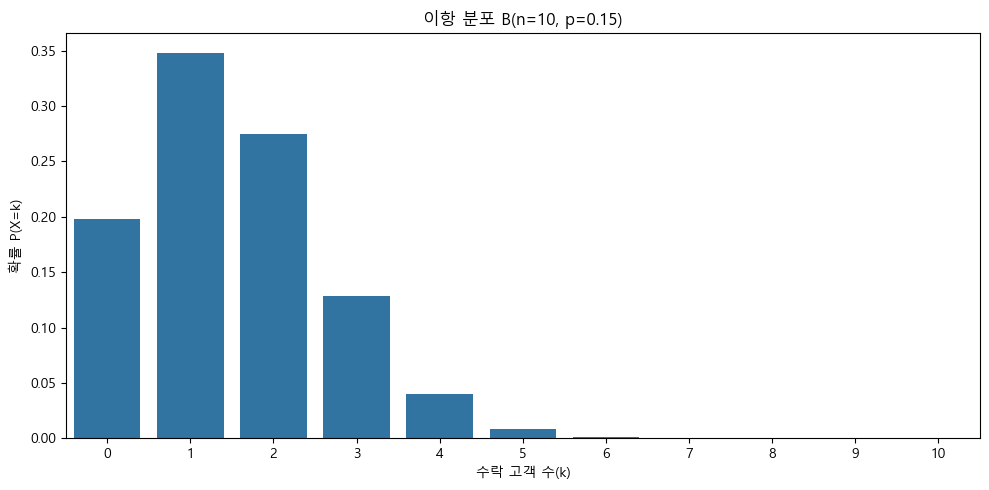

In [16]:
# TODO 2-1(c): 이항분포 PMF 시각화
x = np.arange(0, n_trial+1)
pmf = stats.binom.pmf(x, n_trial, p_response)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=pmf, ax=ax)
ax.set(xlabel='수락 고객 수(k)', ylabel='확률 P(X=k)', title=f'이항 분포 B(n={n_trial}, p={p_response:.2f})')
plt.tight_layout()
plt.show()

In [17]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100


n_trial = n_campaign
p_response = df['Response'].mean()
mean_num = stats.binom(n_trial, p_response).mean()

prob_15_more = stats.binom.sf(14, n_trial, p_response) #P(X > x)


min_accept_90 = stats.binom.ppf(0.1, n_trial, p_response)
print(mean_num, prob_15_more, min_accept_90) #10
#90%확률로 최소 10명 이상 수락이 보장


14.937388193202148 0.5358059894078708 10.0


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

NameError: name 'web_visits' is not defined

In [19]:
web_visits = df['NumWebVisitsMonth']
# 포아송 : 단위 시간/공간에서 사건이 발생하는 횟수를 모델링한 이산형 확률분포
# 람다 : 단위 시간당 발생횟수 #평균 == 분산 -> 포아송 분포랑 잘맞는다


# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lambda_hat = web_visits.mean()

x_pois = np.arange(0, web_visits.max()+1)
observed_freq = web_visits.value_counts().sort_index()
print(observed_freq)
observed_pmf = observed_freq / len(web_visits)
print(observed_pmf)


theory_pmf = stats.poisson.pmf(x_pois, lambda_hat)
print(theory_pmf)


print(web_visits.mean(), web_visits.var()) #5.318872987477639 5.88977340



NumWebVisitsMonth
0      11
1     152
2     202
3     205
4     217
5     280
6     339
7     393
8     342
9      83
10      3
13      1
14      2
17      1
19      2
20      3
Name: count, dtype: int64
NumWebVisitsMonth
0     0.004919
1     0.067979
2     0.090340
3     0.091682
4     0.097048
5     0.125224
6     0.151610
7     0.175760
8     0.152952
9     0.037120
10    0.001342
13    0.000447
14    0.000894
17    0.000447
19    0.000894
20    0.001342
Name: count, dtype: float64
[4.89827103e-03 2.60532815e-02 6.92870475e-02 1.22843002e-01
 1.63346581e-01 1.73763943e-01 1.54038057e-01 1.17044123e-01
 7.78178532e-02 4.59892530e-02 2.44610996e-02 1.18277711e-02
 5.24253434e-03 2.14495187e-03 8.14909039e-04 2.88959845e-04
 9.60587946e-05 3.00543840e-05 8.88085840e-06 2.48611357e-06
 6.61166116e-07]
5.318872987477639 5.889773404889684


In [ ]:
len(observed_pmf)
len(theory_pmf)

In [ ]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
observed_pmf = [observed_pmf.get(k, 0) for k in x_pois]
compared_df = pd.DataFrame({
    '웹 방문 수': np.tile(x_pois, 2),
    '확률' : np.concatenate([observed_pmf, theory_pmf]),
    '유형' : ['관측 PMF'] * len(observed_pmf) + ['이론 PMF'] * len(theory_pmf)
})
display(compared_df)


In [ ]:
compared_df.info()

In [ ]:

sns.barplot(data=compared_df, x='웹 방문 수', y='확률', hue='유형')
plt.tight_layout()
plt.show()

In [ ]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

prob_10_more = stats.poisson.sf(9, lambda_hat) #이론
print(prob_10_more) #0.04491858697430207 #4%


prob_10_more_obs = (web_visits >= heavy_threshold).mean()
print(prob_10_more_obs) #0.5%

# 실무에서는 실측 데이터로 추정하는게 더 정확!!!
visit_95_theory = stats.poisson.ppf(0.95, lambda_hat)
visit_95_obs = web_visits.quantile(0.95) #상위 5%고객의 방문수
print(visit_95_theory, visit_95_obs)
# 서버는 월 8~9회 이상의 접속을 수용

### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [ ]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교

mu = df['Income'].mean()
sigma = df['Income'].std()
prob_30000_below = stats.norm.cdf(30000, mu , sigma) 
prob_80000_over = 1 - stats.norm.cdf(80000, mu , sigma)
income_90th = stats.norm.ppf(0.9, mu, sigma)
print(prob_30000_below, prob_80000_over, income_90th)

obs_prob_30000_below = (df['Income'] < 30000).mean()
obs_prob_80000_over = (df['Income'] > 80000).mean()
obs_income_90th = df['Income'].quantile(0.9)
print(obs_prob_30000_below, obs_prob_80000_over, obs_income_90th)


In [ ]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df['Income'], stat='density', ax=ax, label='실측 분포')
x_norm = np.linspace(df['Income'].min(), df['Income'].max(), 300)
norm_pdf = stats.norm.pdf(x_norm, mu, sigma)
ax.plot(x_norm, norm_pdf, label=f'정규분포 N({mu:.2f},{sigma:.2f})', color='red')
ax.set(xlabel='Income', ylabel='밀도', title='Income 실측과 이론 분포 비교')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
vip_thres_theory = stats.norm.ppf(0.95, mu, sigma)
discount_thres_theory = stats.norm.ppf(0.1, mu, sigma)
vip_thres_obs = df['Income'].quantile(0.95)
discount_thres_obs = df['Income'].quantile(0.1)

print(vip_thres_theory, discount_thres_theory)
print(vip_thres_obs, discount_thres_obs)

---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [ ]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE

# (1) 직접 t분포를 이용해서 추정
data = df['Total_Spending']
n = len(data)
mean_sp = data.mean()
se_sp = data.std() / np.sqrt(n) #표준오차
se_sp2 = stats.sem(data) 
print(mean_sp, se_sp, se_sp2)

for conf in [0.9, 0.95, 0.99] :
    # CI = x̄ ± t(α/2, n-1) × SE
    a = (1-conf)
    t_crit = stats.t.ppf(1-a/2, df=n-1)
    margin = t_crit * se_sp
    ci_lower = mean_sp - margin
    ci_upper = mean_sp + margin
    print(f"{conf:.2f} CI : [{ci_lower:.2f}, {ci_upper:.2f}]")
    
    # (2) 라이브러리로 추정
    print(stats.t.interval(conf, df=n-1, loc=mean_sp, scale=se_sp))




In [ ]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프

groups = ['Low', 'Mid', 'High']
for g in groups:
    gdata = df[df['Income_Group']==g]['Total_Spending']
    print(g, stats.t.interval(0.95, df=len(gdata)-1, loc=gdata.mean(), scale=stats.sem(gdata)))


sns.barplot(data=df, x='Income_Group', y='Total_Spending', errorbar=('ci', 95))
plt.show()


### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [ ]:
# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

t_stat, p_value = stats.ttest_ind(no_child, yes_child, equal_var=False)
# cohend_d = (yes_mean - no_mean) / sqrt((yes_var*(n_yes-1) + no_var*(n_no-1)) / (n_yes+n_no - 2))
cohend_d = (no_child.mean() - yes_child.mean()) / np.sqrt((yes_child.var()*(len(yes_child)-1) + no_child.var()*(len(no_child)-1)) / (len(yes_child)+ len(no_child) -2))
print(t_stat, p_value, cohend_d)


# p_value가 0.05보다 작아서 귀무가설 기각!-> 두 집단간의 차이가 있다
# 효과 크기도 큰 효과다 
# 두 집단이 큰 차이가 있다!

In [ ]:
# TODO 3-2(c): 박스플롯 비교 시각화
sns.boxplot(data=df, x='Has_Children', y='Total_Spending')
plt.show()



### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [ ]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
diff = wines - meat
t_pair, p_pair = stats.ttest_rel(wines, meat)
d_pair = diff.mean() / diff.std() 

print(t_pair, p_pair, d_pair)
# p_value 0.05보다 작아서 귀무가설 기각
# 효과크기는 작은 효과 크기 이므로 차이가 별로 없다.


In [ ]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프

sns.histplot(diff)
plt.show()


In [ ]:
melt_df = df[['MntWines', 'MntMeatProducts']].melt(var_name='카테고리', value_name='소비액') #컬럼이름이 -> 값으로 들어감
display(melt_df)

# sns.barplot(data=melt_df, x='카테고리', y='소비액', errorbar='se') #se는 표준 오차
sns.barplot(data=melt_df, x='카테고리', y='소비액', errorbar=('ci', 95)) #ci는 신뢰구간
plt.show()



### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [ ]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
# 검정력 : 1 - B  = 대립가설이 참일 때 귀무가설을 올바르게 기각할 확률
power = power_analysis.solve_power(
    effect_size = abs(d_pair), #효과크기
    nobs1 = len(no_child), #표본 크기
    ratio = len(yes_child) / len(no_child), #표본 비율
    alpha=0.05
)
print(power)



# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
n_need = power_analysis.solve_power(
    effect_size = 0.2,
    power=0.8,
    ratio = 1,
    alpha=0.05
)
print(n_need) #393.4056930002526
# 검정력 80% 이상으로 효과크기 0.2를 탐지하기 위해 필요한 그룹당 표본 크기



---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [20]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
# 3 독립 집단의 평균을 비교하는데, 정규성이 하나라도 만족하지 않으면 크루스칼 비모수 검정
# 3 독립 집단의 평균을 비교하는데, 정규성이 만족, 등분산성도 만족 -> 원 웨이 아노바
# 3 독립 집단의 평균을 비교하는데, 정규성이 만족, 등분산성도 만족 x -> 웰치시 아노바

for g in edu_groups :
    gdata = df[df['Education_Group']==g]['Total_Spending']
    stat, p = stats.shapiro(gdata)
    print(g, p, len(gdata)) #p가 0.05보다 작다  p값이 0.05보다 커야 정규성을 만족한다 


# stat, p = stats.levene(df[df['Education_Group']=='a집단']['Total_Spending'],df[df['Education_Group']=='b집단']['Total_Spending'],df[df['Education_Group']=='c집단']['Total_Spending']   )
stat, p = stats.levene(*[df[df['Education_Group']==g]['Total_Spending'] for g in edu_groups])
print(p) # p가 0.05보다 커야 등분산성을 만족한다고 해석


Undergraduate 5.543648052614619e-19 255
Graduate 3.561909628976696e-29 1126
Postgraduate 1.7757879312718283e-25 855
1.8306692793099772e-06


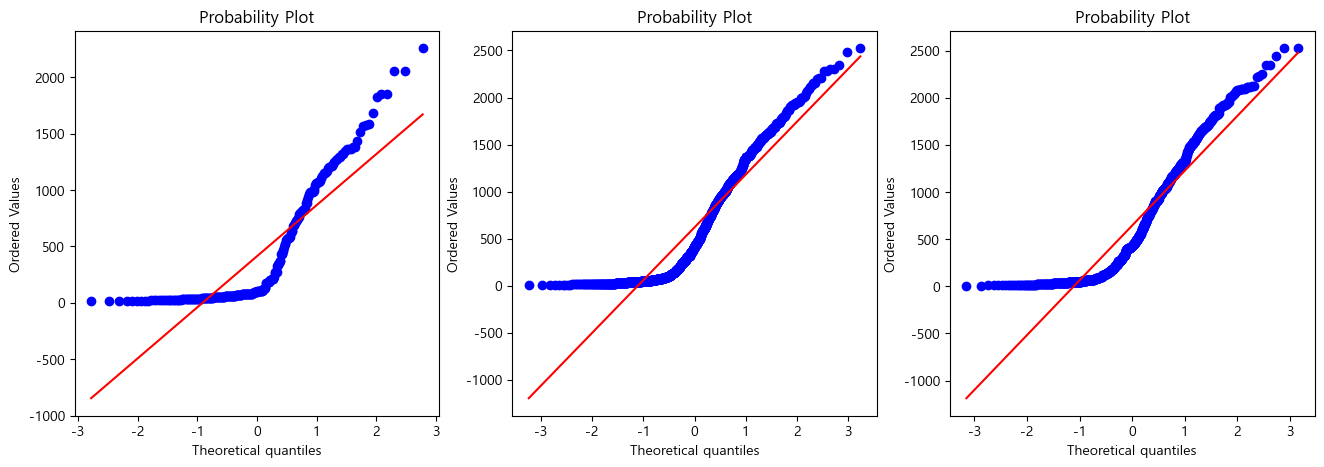

In [21]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for g, ax in zip(edu_groups, axes) :
    gdata = df[df['Education_Group']==g]['Total_Spending']
    stats.probplot(gdata, dist='norm', plot=ax)

plt.show()


### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η², ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [ ]:
df.head()

In [ ]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
import pingouin as pg
result = pg.welch_anova(data=df, dv='Total_Spending', between='Education_Group')
display(result)
# Source	ddof1	ddof2	F	p-unc	np2
# 0	Education_Group	2	751.708152	19.817377	4.098696e-09	0.0137
# 그룹간의 차이가 있다!
# 에타제곱 효과 크기 : 0.0137 작은 효과 크기
result = pg.kruskal(data=df, dv='Total_Spending', between='Education_Group')
display(result)


# TODO 4-2(b): η², ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)
result = pg.anova(data=df, dv='Total_Spending', between='Education_Group', detailed=True)
display(result)
SS = result['SS'][0]
df_k_1 = result['DF'][0]
ms = result['MS'][1]
ss_total = result['SS'].sum()
omega_square = (SS-df_k_1*ms) / (ss_total + ms)
print(omega_square) #작은 효과 크기다!

,Source,ddof1,ddof2,F,p-unc,np2
0,Education_Group,2,751.708152,19.817377,4.098696e-09,0.0137


,Source,ddof1,H,p-unc
Kruskal,Education_Group,2,36.613323,1.120774e-08


,Source,SS,DF,MS,F,p-unc,np2
0,Education_Group,1.109189e+07,2,5.545944e+06,15.508841,2.046193e-07,0.0137
1,Within,7.985182e+08,2233,3.575989e+05,NaN,NaN,NaN


0.01281123840913708


In [ ]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g

gh = pg.pairwise_gameshowell(
    data=df,  dv='Total_Spending', between='Education_Group',
)
display(gh)
# - 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

# 교육 수준별로 소비 차이가 있으나 효과크기는 작다! 큰 차이는 없다!


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Graduate,Postgraduate,620.394316,644.791813,-24.397497,27.691976,-0.881031,1808.339544,6.523632e-01,-0.040121
1,Graduate,Undergraduate,620.394316,412.254902,208.139414,36.852786,5.647861,425.032927,8.920656e-08,0.355688
2,Postgraduate,Undergraduate,644.791813,412.254902,232.536911,38.554847,6.031328,492.811108,9.577128e-09,0.389636


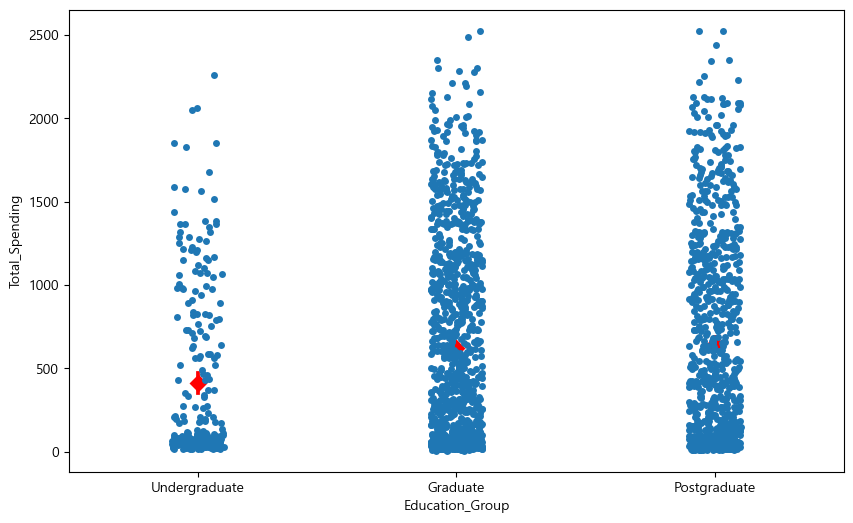

In [ ]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드
fig, ax = plt.subplots(figsize=(10, 6))
qq_colors = ['red', 'red', 'red']
sns.stripplot(data=df, x='Education_Group', y='Total_Spending', order=edu_groups, ax=ax)
sns.pointplot(data=df, x='Education_Group', y='Total_Spending', order=edu_groups, ax=ax, markers='D', palette=qq_colors) #평균

plt.show()




### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [ ]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])
display(crosstab_no_margin)
# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
chi2, p_chi, dof, expected = stats.chi2_contingency(crosstab_no_margin)
print(chi2, p_chi, dof,) #9.236758434275565 0.002372044985880111 1
display(expected)

# TODO 4-3(b): φ (phi) 계산
n_total = crosstab_no_margin.sum().sum() #전체 집단 크기
phi = np.sqrt(chi2 / n_total)
print(phi) #0.064 #작은 효과 크기다!
# 집단간의 차이가 있으나 무시할 수준이다!


# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
a = crosstab_no_margin.loc['Single', True] #싱글이면서 캠페인 반응
b = crosstab_no_margin.loc['Single', False] #싱글이면서 캠페인 반응 x
c = crosstab_no_margin.loc['Together', True] #결혼이면서 캠페인 반응
d = crosstab_no_margin.loc['Together', False] #결혼이면서 캠페인 반응 x
odds_ratio = (a*d) / (b*c)
print(odds_ratio) #1.3521601
# 싱글 고객이 결혼한 고객 대비 캠페인에 반응할 오즈가 1.35배이다!

print(df[df['Marital_Group']=='Single']['Campaign_Response'].mean())
print(df[df['Marital_Group']=='Together']['Campaign_Response'].mean())
# 0.3110831234256927
# 0.2503467406380028



Campaign_Response,False,True
Marital_Group,,
Single,547,247
Together,1081,361


9.236758434275565 0.002372044985880111 1


array([[ 578.10017889,  215.89982111],
       [1049.89982111,  392.10017889]])

0.06427230766297097
1.3521601077648417
0.3110831234256927
0.2503467406380028


<Axes: xlabel='Marital_Group'>

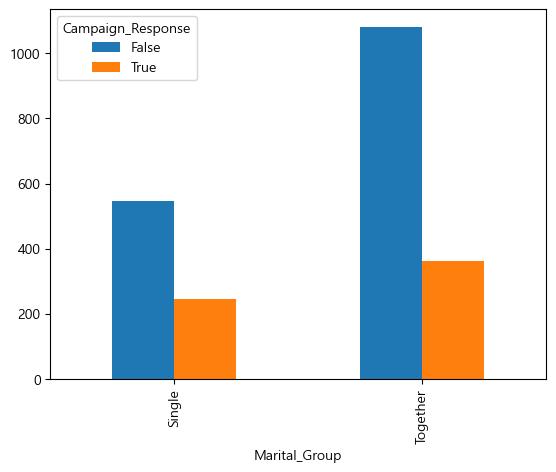

In [ ]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵
crosstab_no_margin.plot(kind='bar')




Campaign_Response,False,True
Marital_Group,,
Single,-1.293485,2.116590
Together,0.959818,-1.570596


<Axes: xlabel='Campaign_Response', ylabel='Marital_Group'>

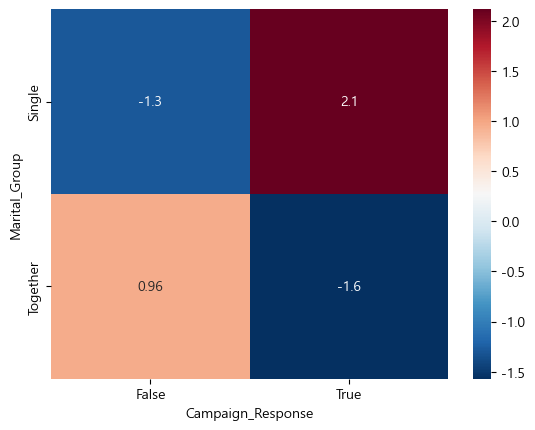

In [38]:
# 표준화 잔차
residuals = (crosstab_no_margin - expected) / np.sqrt(expected)
display(residuals)
sns.heatmap(residuals, annot=True, cmap='RdBu_r')

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [48]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
expected = np.full(3, observed.sum() / 3) #기대 빈도
display(observed)
display(expected)

chi2, p_gof = stats.chisquare(observed, expected)
print(chi2, p_gof)

# TODO 4-4(b): Cohen's w 계산
observed_p = observed / observed.sum()
expected_p = expected / expected.sum()
cohen_d = np.sqrt(np.sum((observed_p-expected_p)**2 / expected_p))
print(cohen_d) #0.3061, 중간 효과 크기
# 0.1 작은 0.3 중간 0.5 큰

# 각 구매 채널 별로 중간 효과 크기로 차이가 있다!



array([ 9140,  5955, 12959])

array([9351.33333333, 9351.33333333, 9351.33333333])

2630.1062950024952 0.0
0.3061887670972692


In [51]:
channel_names

['Web', 'Catalog', 'Store']

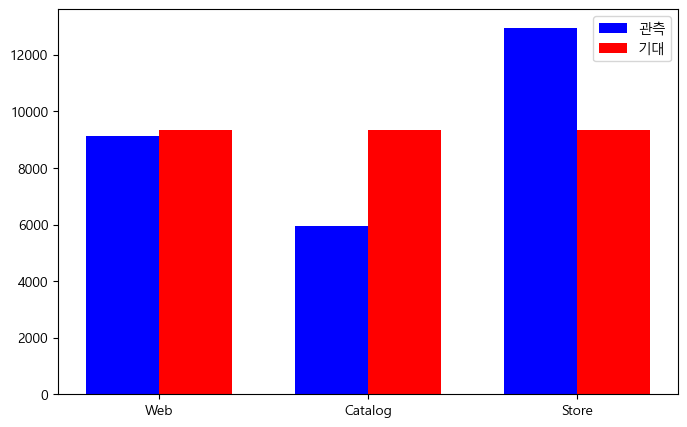

In [55]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프

fig, ax = plt.subplots(figsize=(8, 5))
x_pos = np.arange(3)
width = 0.35
ax.bar(x_pos-width/2, observed, width=width, color='blue', label='관측',)
ax.bar(x_pos+width/2, expected, width=width, color='red', label='기대')

ax.set_xticks(x_pos)
ax.set_xticklabels(channel_names)

ax.legend()
plt.show()


---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [60]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
df_corr = df[corr_vars]
pearson_corr = df_corr.corr(method='pearson')
display(pearson_corr)
spearman_corr = df_corr.corr(method='spearman')
display(spearman_corr)


# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
from itertools import combinations
print(list(combinations(corr_vars, 2)))
for v1, v2 in combinations(corr_vars, 2) :
    r, p = stats.pearsonr(df[v1], df[v2])
    print((v1, v2), r, p) #r은 0~1사이 




,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.000000,0.198835,0.789375,0.738647,-0.646382,0.007829
Age,0.198835,1.000000,0.113618,0.173004,-0.117498,0.019396
Total_Spending,0.789375,0.113618,1.000000,0.821091,-0.499909,0.020842
Total_Purchases,0.738647,0.173004,0.821091,1.000000,-0.426734,0.006426
NumWebVisitsMonth,-0.646382,-0.117498,-0.499909,-0.426734,1.000000,-0.021850
Recency,0.007829,0.019396,0.020842,0.006426,-0.021850,1.000000


,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.000000,0.216515,0.849491,0.776796,-0.640295,0.009743
Age,0.216515,1.000000,0.157677,0.179340,-0.129426,0.020109
Total_Spending,0.849491,0.157677,1.000000,0.908447,-0.476821,0.019979
Total_Purchases,0.776796,0.179340,0.908447,1.000000,-0.420867,0.011726
NumWebVisitsMonth,-0.640295,-0.129426,-0.476821,-0.420867,1.000000,-0.022259
Recency,0.009743,0.020109,0.019979,0.011726,-0.022259,1.000000


[('Income', 'Age'), ('Income', 'Total_Spending'), ('Income', 'Total_Purchases'), ('Income', 'NumWebVisitsMonth'), ('Income', 'Recency'), ('Age', 'Total_Spending'), ('Age', 'Total_Purchases'), ('Age', 'NumWebVisitsMonth'), ('Age', 'Recency'), ('Total_Spending', 'Total_Purchases'), ('Total_Spending', 'NumWebVisitsMonth'), ('Total_Spending', 'Recency'), ('Total_Purchases', 'NumWebVisitsMonth'), ('Total_Purchases', 'Recency'), ('NumWebVisitsMonth', 'Recency')]
('Income', 'Age') 0.19883507696028258 2.2695941325582678e-21
('Income', 'Total_Spending') 0.789374914644683 0.0
('Income', 'Total_Purchases') 0.7386473661631371 0.0
('Income', 'NumWebVisitsMonth') -0.6463819693644642 9.867293377702785e-265
('Income', 'Recency') 0.007829289360304546 0.7113696294008885
('Age', 'Total_Spending') 0.11361767213727983 7.163790026911346e-08
('Age', 'Total_Purchases') 0.17300363019652992 1.7462973979112387e-16
('Age', 'NumWebVisitsMonth') -0.11749756710986493 2.514896850646793e-08
('Age', 'Recency') 0.019396

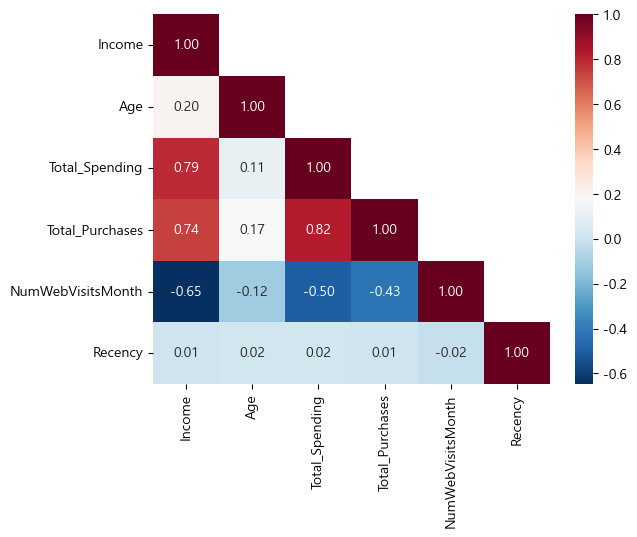

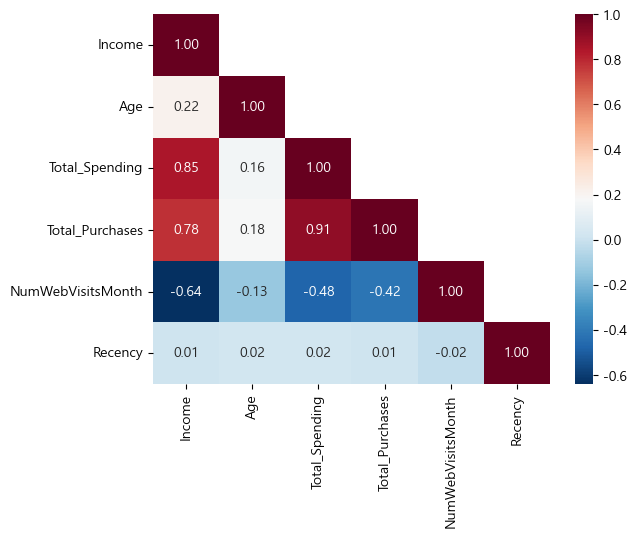

In [65]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)

mask = np.triu(np.ones_like(pearson_corr), k=1)
sns.heatmap(pearson_corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r')
plt.show()

mask = np.triu(np.ones_like(pearson_corr), k=1)
sns.heatmap(spearman_corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r')
plt.show()

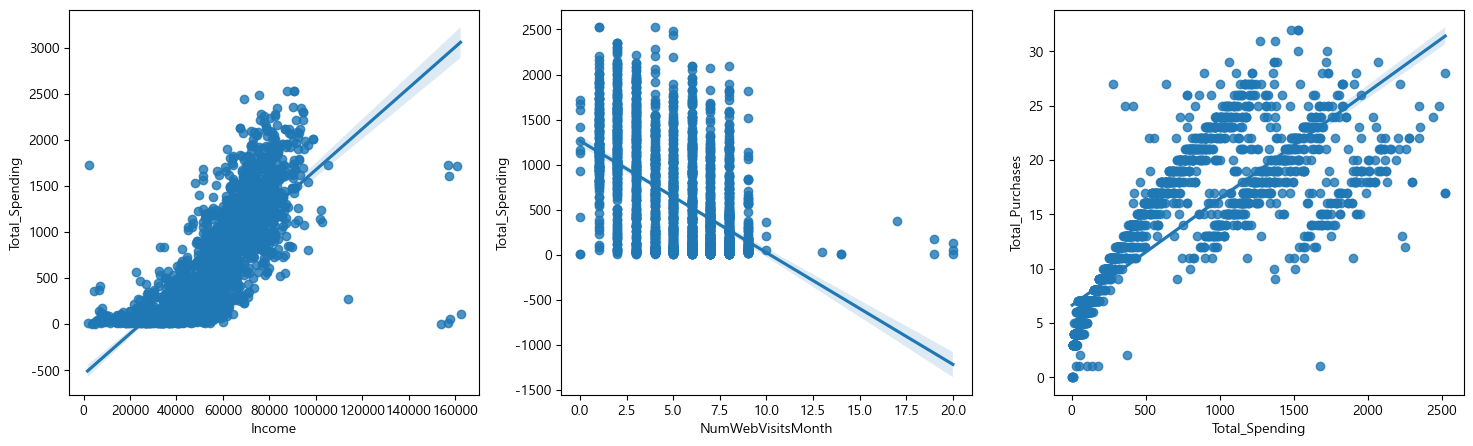

In [ ]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)

pairs = [
    ('Income', 'Total_Spending'), ('NumWebVisitsMonth', 'Total_Spending'), ('Total_Spending', 'Total_Purchases')
]

fig, axes = plt.subplots(1,3, figsize=(18, 5))
for ax, (xvar, yvar) in zip(axes, pairs) :
    sns.regplot(data=df, x=xvar, y=yvar, ci=95, ax=ax)

plt.show()


### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [76]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
z_stat, p_z = proportions_ztest([conv_a, conv_b], [n_a, n_b]) #반응합계, 표본크기
print(z_stat, p_z) # 두 집단의 수락률차이가 있다!

# TODO 5-2(b): Cohen's h 효과 크기
cohens_h = proportion_effectsize(rate_a, rate_b)
print(cohens_h) # 0.2, 작은 0.5  중간  0.8 큰
# 큰 효과크기

# TODO 5-2(c): Wilson 신뢰구간
# 각 집단의 수락률 비율을 95% 신뢰구간으로 추정
ci_a = proportion_confint(conv_a, n_a, alpha=0.05, method='wilson')
ci_b = proportion_confint(conv_b, n_b, alpha=0.05, method='wilson')
print(ci_a) #(0.07039586115479846, 0.09600899871214175)
print(ci_b) #(0.3630763884032965, 0.4523114471540749)


-17.435692501112072 4.4217089462117046e-68
-0.8016212123405796
(0.07039586115479846, 0.09600899871214175)
(0.3630763884032965, 0.4523114471540749)


In [78]:
group_a

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Total_Purchases,Total_Accepted,Has_Children,Income_Group,Age_Group,Education_Group,Marital_Group,Campaign_Response,Customer_Days,Prior_Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,22,1,False,Mid,60대 이상,Graduate,Single,True,663,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,4,0,True,Mid,60대 이상,Graduate,Single,False,113,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,20,0,False,High,50대,Graduate,Together,False,312,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,True,Low,40대,Graduate,Together,False,139,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,14,0,True,Mid,40대,Postgraduate,Together,False,161,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,8080,1986,Graduation,Single,26816.0,0,0,2012-08-17,50,5,...,3,0,False,Low,30대 이하,Graduate,Single,False,681,0
2234,8372,1974,Graduation,Married,34421.0,1,0,2013-07-01,81,3,...,3,0,True,Low,50대,Graduate,Together,False,363,0
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,16,0,True,Mid,50대,Graduate,Together,False,381,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,21,0,True,High,60대 이상,Postgraduate,Together,False,156,0


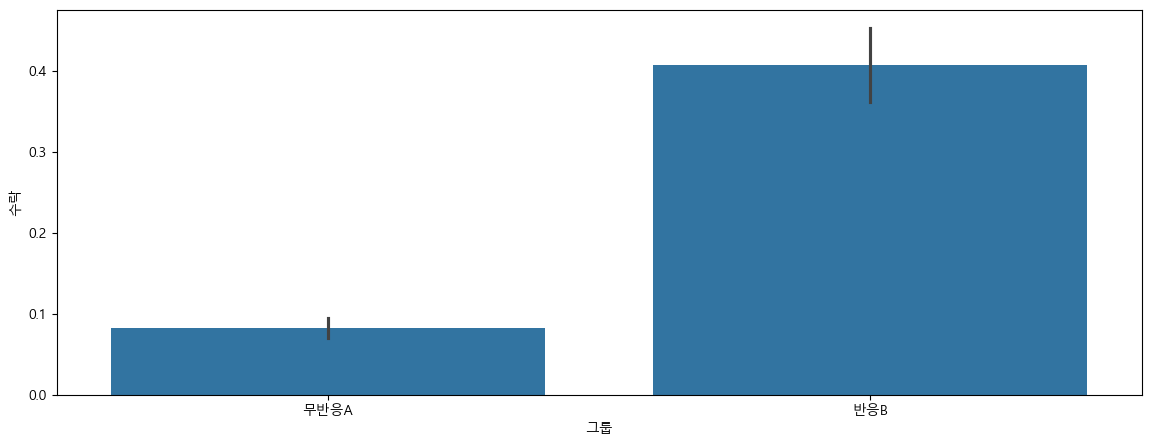

In [ ]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)

fig, ax = plt.subplots(figsize=(14, 5))
rate_df = pd.DataFrame({
    '그룹':['무반응A', '반응B'],
    '수락률': [rate_a, rate_b],
    'ci_low': [ci_a[0], ci_b[0]],
    'ci_high': [ci_a[1], ci_b[1]],
})

plot_df = pd.DataFrame({
    '그룹':['무반응A']*n_a + ['반응B']*n_b,
    '수락': list(group_a['Response']) + list(group_b['Response'])
})

sns.barplot(data=plot_df, x='그룹', y='수락', ax=ax, errorbar='ci')

plt.show()


> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [ ]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
h = proportion_effectsize(baseline_rate, target_rate)

# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)
power_prob = NormalIndPower()
n_need = power_prob.solve_power(
    effect_size=abs(h),
    alpha=0.05,
    power=0.8,
    ratio=1,
    alternative='larger'
    
)

print(h, n_need) #4137.79
#그룹당 4,138명 정도가 필요하다
# 총 필요한 사람 수 4,138*2



-0.05466566903304804 4137.793429568724


---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [81]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

results = df.groupby(['Income_Group', 'Has_Children']).agg(
    고객수=('ID', 'count'),
    평균소득=('Income', 'mean'),
    평균소비=('Total_Spending', 'mean'),
    중앙값소비=('Total_Spending', 'median'),
    평균구매수=('Total_Purchases', 'mean'),
    캠페인반응률=('Campaign_Response', 'mean'),
    와인비중=('MntWines', lambda x : x.sum() / df.loc[x.index, 'Total_Spending'].sum()),
    웹방문=('NumWebVisitsMonth', 'mean'),

)
display(results)


고객수          평균소득         평균소비   중앙값소비      평균구매수  \
Income_Group Has_Children                                                      
Low          False         115  24380.243478   145.008696    73.0   6.400000   
             True          631  29172.879556    86.686212    54.0   5.670365   
Mid          False          80  52209.631250   721.237500   653.0  15.362500   
             True          665  51466.093985   426.254135   368.0  12.338346   
High         False         442  78697.963801  1424.024887  1383.0  19.219457   
             True          303  71841.607261  1033.115512  1005.0  19.178218   

                             캠페인반응률      와인비중       웹방문  
Income_Group Has_Children                                
Low          False         0.130435  0.219537  6.930435  
             True          0.169572  0.357813  6.901743  
Mid          False         0.350000  0.494203  4.675000  
             True          0.198496  0.599854  5.869173  
High         False         0.545249  0.441630  2.366516  
             True          0.280528  0.575902  4.679868

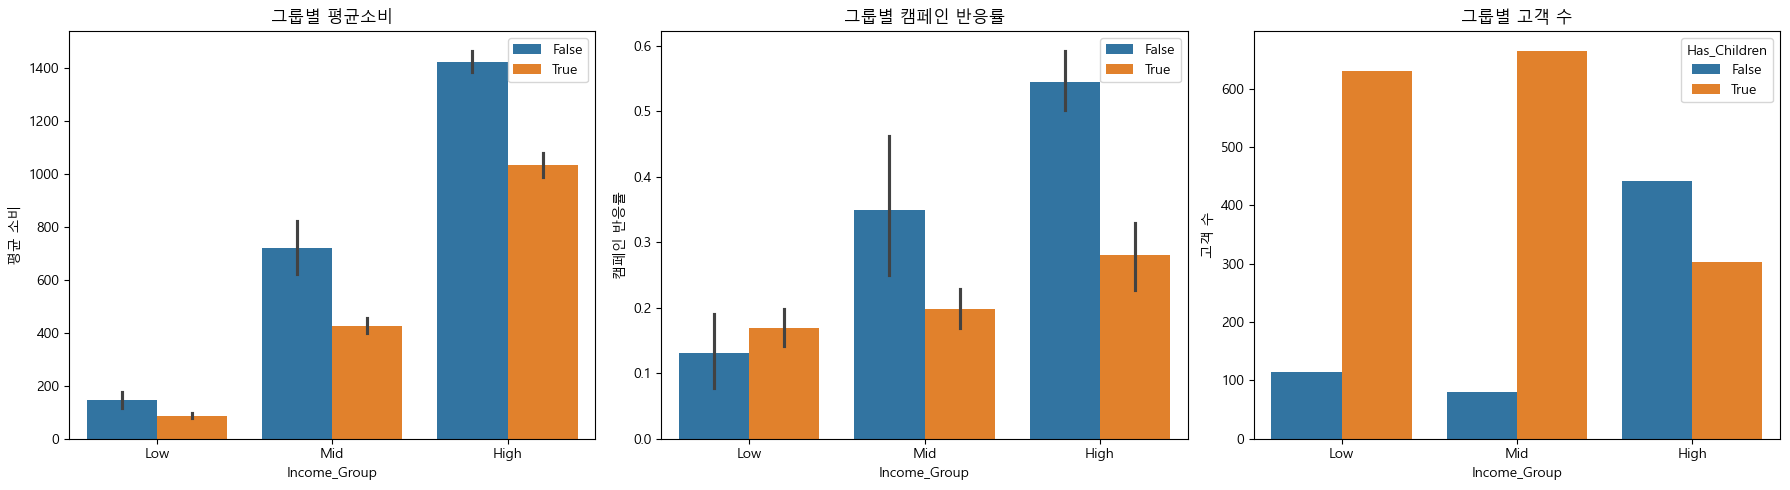

In [87]:
chart_cfg = [
    ('Total_Spending', '평균 소비', '그룹별 평균소비'),
    ('Campaign_Response', '캠페인 반응률', '그룹별 캠페인 반응률'),
            
             ]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (col, ylabel, title) in zip(axes[:2], chart_cfg) :
    sns.barplot(data=df, x='Income_Group', y=col, hue='Has_Children', ax=ax)
    ax.set(xlabel='Income_Group', ylabel=ylabel, title=title)
    ax.legend()

sns.countplot(data=df, x='Income_Group', hue='Has_Children', ax=axes[2])
axes[2].set(xlabel='Income_Group', ylabel='고객 수', title='그룹별 고객 수')

plt.tight_layout()
plt.show()


### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [ ]:
# TODO C-2: 비즈니스 제안서 작성

# 타겟 고객
# 고소득 / 무자녀 : 반응률 54.5%, 평균소비 1,424, 고객 442명
# 고소득 / 유자녀 : 반응률 28.1%, 평균소비 1,033, 고객 303명
# 중위소득 / 무자녀 : 반응률 35%, 평균소비 721, 고객 80명

# 채널 전략
# 고소득 : 카탈고르 구매 평균 5.3건 --> 프리미엄 카탈로그 마케팅 강화
# 저소득: 웹 방문 평균 6.9회 --> 온라인 프로모션 집중
# 해당 채널이 전체 구매의 46%


# 기대 효과
# 현재 전체 캠페인 반응률 27.2%
# 최고 그룹 반응률 : 54%  (전체 대비 약 2배)
# 집중 타겟 별 공략으로 반응률을 2% 올리는 것을 목표, A/B테스트 검증 필요
# 그룹당 약 4000명 필요

# 한계점
# - 실제 A/B테스트를 수행을 못했음, 타겟별 전략을 수립했을때 실제 효과가 있는지는 실험을 통해 추후에 결론이남
# - 외부 변수 통제가 안됨 계절, 경쟁사, 경기 지수 같은거 미반영된 상태
# - 이탈 고객이 없어 잔존 고객들만 분석 --> 생존자에 대한 편향으로 분석이 이루어졌다

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛